In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(5997)
tf.random.set_seed(5995)

In [2]:
tf.config.list_physical_devices('GPU')

[]

4431872/4422102 [==============================] - 0s 0us/step


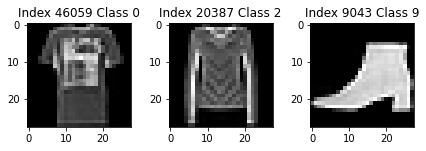

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [5]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# C1 Normal + SGD

In [7]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.8206
Number of Epoch = 1 - Average Cross Entropy:= 0.0053199749755859374 

Validation Accuracy: 0.8166

Train Accuracy: 0.8470
Number of Epoch = 2 - Average Cross Entropy:= 0.0035664651489257814 

Validation Accuracy: 0.8390

Train Accuracy: 0.8551
Number of Epoch = 3 - Average Cross Entropy:= 0.0031891851806640625 

Validation Accuracy: 0.8456

Train Accuracy: 0.8545
Number of Epoch = 4 - Average Cross Entropy:= 0.0029509698486328124 

Validation Accuracy: 0.8428

Train Accuracy: 0.8710
Number of Epoch = 5 - Average Cross Entropy:= 0.002764801330566406 

Validation Accuracy: 0.8568

Train Accuracy: 0.8721
Number of Epoch = 6 - Average Cross Entropy:= 0.0026348583984375 

Validation Accuracy: 0.8561

Train Accuracy: 0.8784
Number of Epoch = 7 - Average Cross Entropy:= 0.0025148597717285157 

Validation Accuracy: 0.8629

Train Accuracy: 0.8823
Number of Epoch = 8 - Average Cross Entropy:= 0.0024214424133300783 

Validation Accuracy: 0.8667

Train Accuracy: 0.8893
Numb

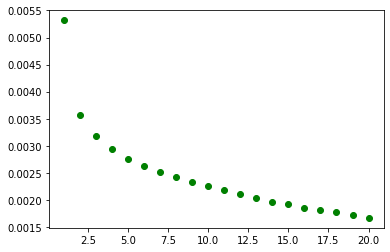

In [8]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


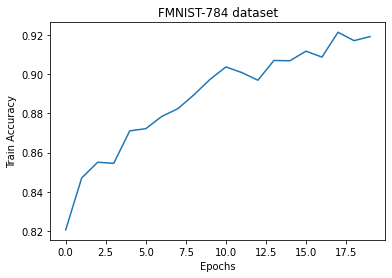

In [9]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [10]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0910

Test Accuracy: 0.88


# C1 Normal + SGD + L2

In [11]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    # backward pass
    # """
    # # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    # with tf.GradientTape() as tape:
    #   predicted = self.forward(X_train)
    #   # print('OK')
    #   current_loss = self.loss(predicted, y_train)
    #   # print('OK')
    # grads = tape.gradient(current_loss, self.variables)
    # # print('OK')
    # return grads, self.variables
    # # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))
 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))


    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      #L1 = (tf.reduce_sum(tf.math.abs(self.W1))+ tf.reduce_sum(tf.math.abs(self.W2))+tf.reduce_sum(tf.math.abs(self.W3)) + tf.reduce_sum(tf.math.abs(self.W4))) # got 94% with just L1.
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)) + tf.reduce_sum(tf.square(self.W4)))/4 # got 97% with just L2.
      current_loss = self.loss(predicted, y_train) + 0.001 * L2 #+ 0.005 * L2 #L1 and L2 togeh
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.8204
Number of Epoch = 1 - Average Cross Entropy:= 0.0052581591796875 

Validation Accuracy: 0.8164

Train Accuracy: 0.8322
Number of Epoch = 2 - Average Cross Entropy:= 0.003568704833984375 

Validation Accuracy: 0.8266

Train Accuracy: 0.8522
Number of Epoch = 3 - Average Cross Entropy:= 0.0031833132934570314 

Validation Accuracy: 0.8443

Train Accuracy: 0.8482
Number of Epoch = 4 - Average Cross Entropy:= 0.0029497036743164062 

Validation Accuracy: 0.8383

Train Accuracy: 0.8648
Number of Epoch = 5 - Average Cross Entropy:= 0.002771936950683594 

Validation Accuracy: 0.8505

Train Accuracy: 0.8739
Number of Epoch = 6 - Average Cross Entropy:= 0.0026517068481445314 

Validation Accuracy: 0.8594

Train Accuracy: 0.8779
Number of Epoch = 7 - Average Cross Entropy:= 0.0025527793884277342 

Validation Accuracy: 0.8634

Train Accuracy: 0.8822
Number of Epoch = 8 - Average Cross Entropy:= 0.00246673828125 

Validation Accuracy: 0.8642

Train Accuracy: 0.8823
Number of 

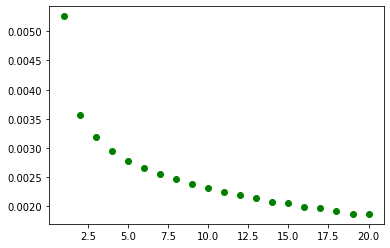

In [12]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


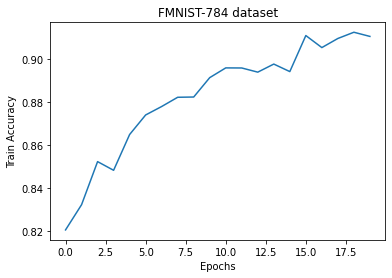

In [13]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [14]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0870

Test Accuracy: 0.88


# C1 Normal + Adam

In [31]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.7997
Number of Epoch = 1 - Average Cross Entropy:= 0.00759494873046875 

Validation Accuracy: 0.7957

Train Accuracy: 0.8295
Number of Epoch = 2 - Average Cross Entropy:= 0.004258280639648437 

Validation Accuracy: 0.8234

Train Accuracy: 0.8401
Number of Epoch = 3 - Average Cross Entropy:= 0.0037801254272460936 

Validation Accuracy: 0.8325

Train Accuracy: 0.8495
Number of Epoch = 4 - Average Cross Entropy:= 0.0035431341552734376 

Validation Accuracy: 0.8396

Train Accuracy: 0.8530
Number of Epoch = 5 - Average Cross Entropy:= 0.0033779580688476562 

Validation Accuracy: 0.8439

Train Accuracy: 0.8584
Number of Epoch = 6 - Average Cross Entropy:= 0.003255558166503906 

Validation Accuracy: 0.8472

Train Accuracy: 0.8629
Number of Epoch = 7 - Average Cross Entropy:= 0.0031570770263671874 

Validation Accuracy: 0.8519

Train Accuracy: 0.8658
Number of Epoch = 8 - Average Cross Entropy:= 0.0030682208251953127 

Validation Accuracy: 0.8537

Train Accuracy: 0.8693
Numb

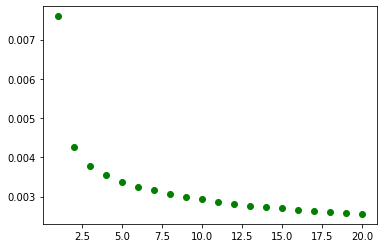

In [32]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


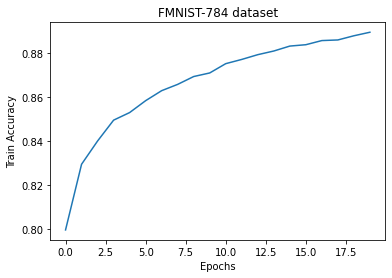

In [33]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [34]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0994

Test Accuracy: 0.87


# C1 Normal + Rmsprop

In [35]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.8267
Number of Epoch = 1 - Average Cross Entropy:= 0.005444076538085938 

Validation Accuracy: 0.8231

Train Accuracy: 0.8454
Number of Epoch = 2 - Average Cross Entropy:= 0.003592818908691406 

Validation Accuracy: 0.8375

Train Accuracy: 0.8576
Number of Epoch = 3 - Average Cross Entropy:= 0.003268118896484375 

Validation Accuracy: 0.8505

Train Accuracy: 0.8634
Number of Epoch = 4 - Average Cross Entropy:= 0.0030803759765625 

Validation Accuracy: 0.8553

Train Accuracy: 0.8710
Number of Epoch = 5 - Average Cross Entropy:= 0.0029385992431640623 

Validation Accuracy: 0.8574

Train Accuracy: 0.8734
Number of Epoch = 6 - Average Cross Entropy:= 0.002854599304199219 

Validation Accuracy: 0.8587

Train Accuracy: 0.8760
Number of Epoch = 7 - Average Cross Entropy:= 0.002813762512207031 

Validation Accuracy: 0.8617

Train Accuracy: 0.8821
Number of Epoch = 8 - Average Cross Entropy:= 0.00276526123046875 

Validation Accuracy: 0.8686

Train Accuracy: 0.8782
Number of 

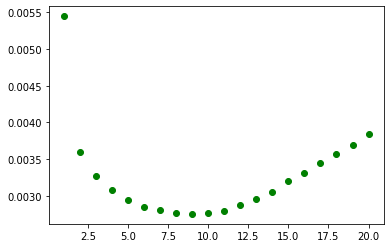

In [36]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


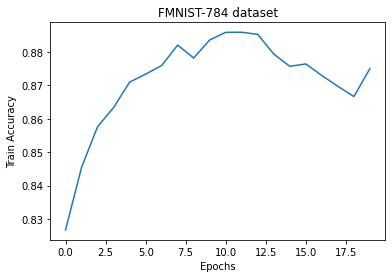

In [37]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [38]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.1758

Test Accuracy: 0.85


# C1 Normal + Custom optimizer (1e-2)



In [39]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      # print('OK')
      current_loss = self.loss(predicted, y_train)
      # print('OK')
    grads = tape.gradient(current_loss, self.variables)
    # print('OK')
    return grads, self.variables
    # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))



    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [40]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
class RectifiedAdam(OptimizerV2):

    def __init__(self,
                 learning_rate=1e-2,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 name='RectifiedAdam', **kwargs):
        super(RectifiedAdam, self).__init__(name, **kwargs)

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('beta_3', beta_3)
        self._set_hyper('decay', self._initial_decay)
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    # def _create_slots(self, var_list):
    #     for var in var_list:
    #         self.add_slot(var, 'm')
    #     for var in var_list:
    #         self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var, gvs):
        for va in var:
            self.add_slot(va, 'm')
        for va in var:
            self.add_slot(va, 'v')
        for va in var:
            self.add_slot(va, 'u')
        var_dtype = var[0].dtype.base_dtype
        # lr_t = self._decayed_lr(var_dtype)
        # m = self.get_slot(var, 'm')
        # v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        beta_3_t = self._get_hyper('beta_3', var_dtype)
        learning_rate = self._get_hyper('learning_rate', var_dtype)

        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

        t = tf.cast(self.iterations + 1, var_dtype)
        update_ops = []

        for (g,var) in gvs:

          m = self.get_slot(var, 'm')
          v = self.get_slot(var, 'v')
          u = self.get_slot(var, 'u')

          m_t = (beta_1_t * m) + (1. - beta_1_t) * g
          # print('###################')
          # print(g)
          v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
          u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g
          # print(u_t)
          beta1_t = beta_1_t ** t
          beta2_t = beta_2_t ** t
          beta3_t = beta_3_t ** t
          
          m_t_hat = m_t/(1-beta1_t)
          v_t_hat = v_t/(1-beta2_t)
          u_t_hat = u_t/(1-beta3_t)

          m_t = tf.compat.v1.assign(m, m_t)
          v_t = tf.compat.v1.assign(v, v_t)
          u_t = tf.compat.v1.assign(u, u_t)
          # print(m_t)
          # print(u_t)
          # dom2 = self.epsilon
          # dom3 = np.cbrt(u_t_hat)*self.epsilon + 1e-5


          update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
          update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)


Train Accuracy: 0.8578
Number of Epoch = 1 - Average Cross Entropy:= 0.00410873291015625 

Validation Accuracy: 0.8493

Train Accuracy: 0.8737
Number of Epoch = 2 - Average Cross Entropy:= 0.0030051693725585936 

Validation Accuracy: 0.8618

Train Accuracy: 0.8826
Number of Epoch = 3 - Average Cross Entropy:= 0.0027238763427734373 

Validation Accuracy: 0.8702

Train Accuracy: 0.8903
Number of Epoch = 4 - Average Cross Entropy:= 0.0025432298278808595 

Validation Accuracy: 0.8737

Train Accuracy: 0.8955
Number of Epoch = 5 - Average Cross Entropy:= 0.0024048406982421877 

Validation Accuracy: 0.8741

Train Accuracy: 0.8996
Number of Epoch = 6 - Average Cross Entropy:= 0.0022955435180664063 

Validation Accuracy: 0.8779

Train Accuracy: 0.9023
Number of Epoch = 7 - Average Cross Entropy:= 0.0021963087463378905 

Validation Accuracy: 0.8815

Train Accuracy: 0.9049
Number of Epoch = 8 - Average Cross Entropy:= 0.0021129165649414064 

Validation Accuracy: 0.8817

Train Accuracy: 0.9088
Nu

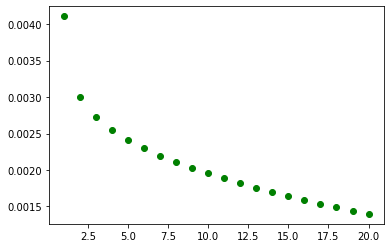

In [41]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
ao = RectifiedAdam(learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-2,
                 weight_decay=0.0,
                 name='RectifiedAdam')
time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

    g,v = mlp_on_cpu.backward(inputs, outputs)
    gvs=zip(g, v)
    # print(g[0],v[1])
    ao._resource_apply_dense(g,v,gvs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


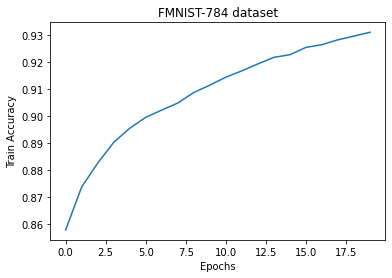

In [42]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [43]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0933

Test Accuracy: 0.88


# C1 Normal + Custom optimizer (1e-3)



In [44]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      # print('OK')
      current_loss = self.loss(predicted, y_train)
      # print('OK')
    grads = tape.gradient(current_loss, self.variables)
    # print('OK')
    return grads, self.variables
    # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))



    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [45]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
class RectifiedAdam(OptimizerV2):

    def __init__(self,
                 learning_rate=1e-3,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 name='RectifiedAdam', **kwargs):
        super(RectifiedAdam, self).__init__(name, **kwargs)

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('beta_3', beta_3)
        self._set_hyper('decay', self._initial_decay)
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    # def _create_slots(self, var_list):
    #     for var in var_list:
    #         self.add_slot(var, 'm')
    #     for var in var_list:
    #         self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var, gvs):
        for va in var:
            self.add_slot(va, 'm')
        for va in var:
            self.add_slot(va, 'v')
        for va in var:
            self.add_slot(va, 'u')
        var_dtype = var[0].dtype.base_dtype
        # lr_t = self._decayed_lr(var_dtype)
        # m = self.get_slot(var, 'm')
        # v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        beta_3_t = self._get_hyper('beta_3', var_dtype)
        learning_rate = self._get_hyper('learning_rate', var_dtype)

        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

        t = tf.cast(self.iterations + 1, var_dtype)
        update_ops = []

        for (g,var) in gvs:

          m = self.get_slot(var, 'm')
          v = self.get_slot(var, 'v')
          u = self.get_slot(var, 'u')

          m_t = (beta_1_t * m) + (1. - beta_1_t) * g
          # print('###################')
          # print(g)
          v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
          u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g
          # print(u_t)
          beta1_t = beta_1_t ** t
          beta2_t = beta_2_t ** t
          beta3_t = beta_3_t ** t
          
          m_t_hat = m_t/(1-beta1_t)
          v_t_hat = v_t/(1-beta2_t)
          u_t_hat = u_t/(1-beta3_t)

          m_t = tf.compat.v1.assign(m, m_t)
          v_t = tf.compat.v1.assign(v, v_t)
          u_t = tf.compat.v1.assign(u, u_t)
          # print(m_t)
          # print(u_t)
          # dom2 = self.epsilon
          # dom3 = np.cbrt(u_t_hat)*self.epsilon + 1e-5


          update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
          update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)


Train Accuracy: 0.8569
Number of Epoch = 1 - Average Cross Entropy:= 0.004172954711914063 

Validation Accuracy: 0.8486

Train Accuracy: 0.8702
Number of Epoch = 2 - Average Cross Entropy:= 0.0030117388916015625 

Validation Accuracy: 0.8591

Train Accuracy: 0.8812
Number of Epoch = 3 - Average Cross Entropy:= 0.0027223074340820314 

Validation Accuracy: 0.8696

Train Accuracy: 0.8899
Number of Epoch = 4 - Average Cross Entropy:= 0.0025410829162597656 

Validation Accuracy: 0.8745

Train Accuracy: 0.8948
Number of Epoch = 5 - Average Cross Entropy:= 0.0024004843139648437 

Validation Accuracy: 0.8777

Train Accuracy: 0.8990
Number of Epoch = 6 - Average Cross Entropy:= 0.002289160919189453 

Validation Accuracy: 0.8788

Train Accuracy: 0.9031
Number of Epoch = 7 - Average Cross Entropy:= 0.0021910791015625 

Validation Accuracy: 0.8803

Train Accuracy: 0.9058
Number of Epoch = 8 - Average Cross Entropy:= 0.002112303314208984 

Validation Accuracy: 0.8817

Train Accuracy: 0.9094
Number

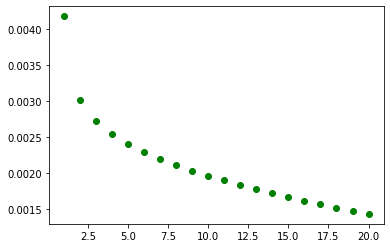

In [46]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
ao = RectifiedAdam(learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-2,
                 weight_decay=0.0,
                 name='RectifiedAdam')
time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

    g,v = mlp_on_cpu.backward(inputs, outputs)
    gvs=zip(g, v)
    # print(g[0],v[1])
    ao._resource_apply_dense(g,v,gvs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


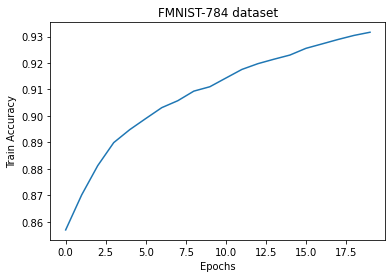

In [47]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [48]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0917

Test Accuracy: 0.88


# C1 Normal + Custom optimizer (1e-4)



In [49]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      # print('OK')
      current_loss = self.loss(predicted, y_train)
      # print('OK')
    grads = tape.gradient(current_loss, self.variables)
    # print('OK')
    return grads, self.variables
    # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))



    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [50]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
class RectifiedAdam(OptimizerV2):

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 name='RectifiedAdam', **kwargs):
        super(RectifiedAdam, self).__init__(name, **kwargs)

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('beta_3', beta_3)
        self._set_hyper('decay', self._initial_decay)
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    # def _create_slots(self, var_list):
    #     for var in var_list:
    #         self.add_slot(var, 'm')
    #     for var in var_list:
    #         self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var, gvs):
        for va in var:
            self.add_slot(va, 'm')
        for va in var:
            self.add_slot(va, 'v')
        for va in var:
            self.add_slot(va, 'u')
        var_dtype = var[0].dtype.base_dtype
        # lr_t = self._decayed_lr(var_dtype)
        # m = self.get_slot(var, 'm')
        # v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        beta_3_t = self._get_hyper('beta_3', var_dtype)
        learning_rate = self._get_hyper('learning_rate', var_dtype)

        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

        t = tf.cast(self.iterations + 1, var_dtype)
        update_ops = []

        for (g,var) in gvs:

          m = self.get_slot(var, 'm')
          v = self.get_slot(var, 'v')
          u = self.get_slot(var, 'u')

          m_t = (beta_1_t * m) + (1. - beta_1_t) * g
          # print('###################')
          # print(g)
          v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
          u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g
          # print(u_t)
          beta1_t = beta_1_t ** t
          beta2_t = beta_2_t ** t
          beta3_t = beta_3_t ** t
          
          m_t_hat = m_t/(1-beta1_t)
          v_t_hat = v_t/(1-beta2_t)
          u_t_hat = u_t/(1-beta3_t)

          m_t = tf.compat.v1.assign(m, m_t)
          v_t = tf.compat.v1.assign(v, v_t)
          u_t = tf.compat.v1.assign(u, u_t)
          # print(m_t)
          # print(u_t)
          # dom2 = self.epsilon
          # dom3 = np.cbrt(u_t_hat)*self.epsilon + 1e-5


          update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
          update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)


Train Accuracy: 0.7969
Number of Epoch = 1 - Average Cross Entropy:= 0.006962353515625 

Validation Accuracy: 0.7926

Train Accuracy: 0.8220
Number of Epoch = 2 - Average Cross Entropy:= 0.00439804443359375 

Validation Accuracy: 0.8147

Train Accuracy: 0.8334
Number of Epoch = 3 - Average Cross Entropy:= 0.003957713623046875 

Validation Accuracy: 0.8245

Train Accuracy: 0.8409
Number of Epoch = 4 - Average Cross Entropy:= 0.0037285498046875 

Validation Accuracy: 0.8310

Train Accuracy: 0.8461
Number of Epoch = 5 - Average Cross Entropy:= 0.003575453186035156 

Validation Accuracy: 0.8370

Train Accuracy: 0.8502
Number of Epoch = 6 - Average Cross Entropy:= 0.00345915771484375 

Validation Accuracy: 0.8413

Train Accuracy: 0.8529
Number of Epoch = 7 - Average Cross Entropy:= 0.0033657403564453124 

Validation Accuracy: 0.8445

Train Accuracy: 0.8559
Number of Epoch = 8 - Average Cross Entropy:= 0.0032883047485351563 

Validation Accuracy: 0.8477

Train Accuracy: 0.8583
Number of Epo

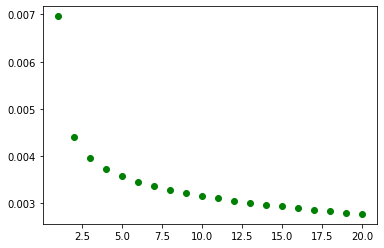

In [51]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
ao = RectifiedAdam(learning_rate=1e-4,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-4,
                 weight_decay=0.0,
                 name='RectifiedAdam')
time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

    g,v = mlp_on_cpu.backward(inputs, outputs)
    gvs=zip(g, v)
    # print(g[0],v[1])
    ao._resource_apply_dense(g,v,gvs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


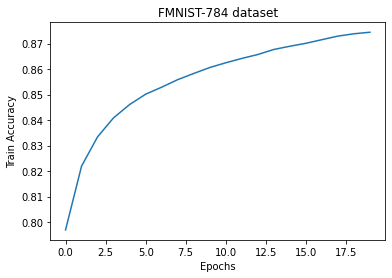

In [52]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

In [53]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.1012

Test Accuracy: 0.86
